In [141]:
from astropy.io import fits, ascii
from astropy.table import Table, Column, hstack
from astropy.time import Time
import numpy as np
import rafias_lib as rl
import pdb, glob, matplotlib, string
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)

## General

In [142]:
telem_table = ascii.read('/data1/tso_analysis/all_tso_cv3/temperatures/cv3_otp821_telem.CSV')
time_list = []
for time in telem_table['Secondary Time']:
    time_list.append(string.replace(string.replace(time, '/', '-'), ' ', 'T'))
Tlist = Time(time_list)
telem_table['JD'] = Tlist.jd
telem_table

Primary Time,Secondary Time,APID,Telemetry Mnemonic,EU Value,Flags,Raw Type,Raw Value,JD
str23,str23,int64,str23,str21,int64,str4,int64,float64
2016/01/11 00:00:00.000,2016/01/10 18:00:57.179,778,INRC_FA_TMC1_SW_HTR_ST,ENABLE,0,CS,1,2457398.25066
2016/01/11 00:00:00.000,2016/01/10 18:00:57.179,778,INRC_FA_TMC2_SW_HTR_ST,ENABLE,0,CS,1,2457398.25066
2016/01/11 00:00:00.000,2016/01/10 18:01:03.227,779,INRC_FB_TMC1_SW_HTR_ST,ENABLE,0,CS,1,2457398.25073
2016/01/11 00:00:00.000,2016/01/10 18:01:03.227,779,INRC_FB_TMC2_SW_HTR_ST,ENABLE,0,CS,1,2457398.25073
2016/01/11 00:00:00.000,2016/01/10 08:21:51.665,-1,IGDP_NRC_FA_TMC2_SWMV_T,9.054495271677895e+01,0,FL32,0,2457397.84851
2016/01/11 00:00:00.000,2016/01/07 20:31:56.977,-1,IGDP_NRC_FB_TMC2_SWMV_T,2.895544870499462e+02,0,FL32,0,2457395.35552
2016/01/11 00:00:00.000,2016/01/10 23:59:42.819,-1,IGDP_NRC_A_T_SWFPAH1,3.736645780735095e+01,5,FL32,0,2457398.4998
2016/01/11 00:00:00.000,2016/01/10 23:59:10.948,-1,IGDP_NRC_B_T_SWFPAH1,3.760912863591025e+01,5,FL32,0,2457398.49943
2016/01/11 00:00:00.000,2016/01/10 23:59:58.639,-1,IGDP_NRC_FA_TMC1_SWMV_T,3.720505137821176e+01,5,FL32,0,2457398.49998


In [143]:
tmnemonic = ['IGDP_NRC_A_T_SWFPAH1', 'IGDP_NRC_FA_TMC1_SWMV_T', 'IGDP_NRC_A_T_OBA_TS1', 'IGDP_NRC_FA_ACE1_SCTEMP',
             'IGDP_NRC_B_T_SWFPAH1', 'IGDP_NRC_FB_TMC1_SWMV_T', 'IGDP_NRC_B_T_OBA_TS1', 'IGDP_NRC_FB_ACE1_SCTEMP']
description = ['A Det Housing Temp', 'A Det Side Temp', 'Optical Bench Temp A', 'Asic Temp A',
               'B Det Housing Temp', 'B Det Side Temp', 'Optical Bench Temp B', 'Asic Temp B']
for n in ['a', 'b']:
    if n == 'a':
        for x, mnm in zip(range(1, 5), tmnemonic[:4]):
            globals()['index_'+n+'%s' % x] = np.where(telem_table['Telemetry Mnemonic'] == mnm)
    else:
        for x, mnm in zip(range(1, 5), tmnemonic[4:]):
            globals()['index_'+n+'%s' % x] = np.where(telem_table['Telemetry Mnemonic'] == mnm)

index_a1, index_a2, index_a3, index_a4, index_b1, index_b2, index_b3, index_b4

((array([     6,     53,    108, ..., 152321, 152371, 152398]),),
 (array([     8,     14,     15, ..., 152390, 152393, 152400]),),
 (array([], dtype=int64),),
 (array([    10,     32,    165, ..., 152262, 152389, 152404]),),
 (array([     7,     24,     80, ..., 152242, 152293, 152399]),),
 (array([     9,     12,     13, ..., 152391, 152392, 152402]),),
 (array([], dtype=int64),),
 (array([    11,    143,    272, ..., 152239, 152365, 152405]),))

In [144]:
x_data = []
y_data = []
for n in ['a', 'b']:
    for i in range(1,5):
        x_data.append(telem_table['JD'][globals()['index_'+n+'%s' % i]])
        y_data.append(telem_table['EU Value'][globals()['index_'+n+'%s' % i]])
len(x_data), len(y_data), len(x_data[0]), len(y_data[7])

(8, 8, 3594, 1199)

In [145]:
def closest_value(array, value):
    ind = (np.abs(array - value)).argmin()
    val = array[ind]
    return ind, val

In [146]:
def time_vars(hdu_filenames):
    "returns stime, etime, stime_ind, etime_ind"
    hdu = fits.open(hdu_filenames[1])
    header = hdu[0].header
    header

    stime_str = header['DATE-OBS']+'T'+header['TIME-OBS']
    etime_str = header['DATE-END']+'T'+header['TIME-END']
    stime = Time(stime_str).jd
    etime = Time(etime_str).jd
    stime_ind = []
    etime_ind = []
    for i in range(0,8):
        if len(x_data[i]) != 0:
            stime_ind.append(closest_value(x_data[i], stime)[0])
            etime_ind.append(closest_value(x_data[i], etime)[0])
        else:
            stime_ind.append(0)
            etime_ind.append(0)
    return stime, etime, stime_ind, etime_ind

In [147]:
def proper_lc(tvar, data):
    jd_time = data['Time']/86400
    x = jd_time + tvar[0]
    y = data['a1_b4_res_flux']
    #Light curve with A detector temperatures
    plt.subplot(2,1,1)
    rl.light_curve(x, y,'r.-', lbl = 'Light curve')
    plt.xlabel('Time (JD)')
    plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
    plt.twinx()
    for i in range(0,4):
        x1 = x_data[i][tvar[2][i]:tvar[3][i]]
        y1 = (y_data[i][tvar[2][i]:tvar[3][i]]).astype(np.float)
        offset = np.median(y1)
        plt.ylabel('Differential Temperature(K)')
        plt.plot(x1, y1 - offset, label = '%s' % description[i])
    plt.legend(loc='upper left', bbox_to_anchor=(1.1, 0.85))
    #Light curve with B detector temperatures
    plt.subplot(2,1,2)
    rl.light_curve(x, y,'r.-', lbl = 'Light curve')
    plt.xlabel('Time (JD)')
    plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1))
    plt.twinx()
    for i in range(4,8):
        x1 = x_data[i][tvar[2][i]:tvar[3][i]]
        y1 = (y_data[i][tvar[2][i]:tvar[3][i]]).astype(np.float)
        offset = np.median(y1)
        plt.ylabel('Differential Temperature(K)')
        plt.plot(x1, y1 - offset, label = '%s' % description[i])
    plt.legend(loc='upper left', bbox_to_anchor=(1.1, 0.85))

## Test 1 (WLP8SUB)

In [148]:
hdu_filenames_a11 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'+
                              '/NRCN821WLP8SUB-6012134600_1_481_SE_2016-01-12T16h42m53/*.slp.fits')
len(hdu_filenames_a11)

306

In [149]:
hdu_filenames_b41 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'+
                              '/NRCN821WLP8SUB-6012134957_1_489_SE_2016-01-12T16h43m29/*.slp.fits')
len(hdu_filenames_b41)

307

In [150]:
centers_a11 = rl.gen_center_g2d(166,160,5,400,2,2,0,hdu_filenames_a11)[0]
centers_b41 = rl.gen_center_g2d(162,156,5,500,2,2,0,hdu_filenames_b41)[0]
data1 = rl.average_residual_flux(centers_a11, centers_b41, 90, 100, 110, hdu_filenames_a11, hdu_filenames_b41)

In [151]:
tvar1 = time_vars(hdu_filenames_a11)
tvar1

(2457400.0791508215,
 2457400.15841375,
 [1885, 36738, 0, 628, 1740, 37223, 0, 645],
 [1980, 36825, 0, 649, 1828, 37309, 0, 666])

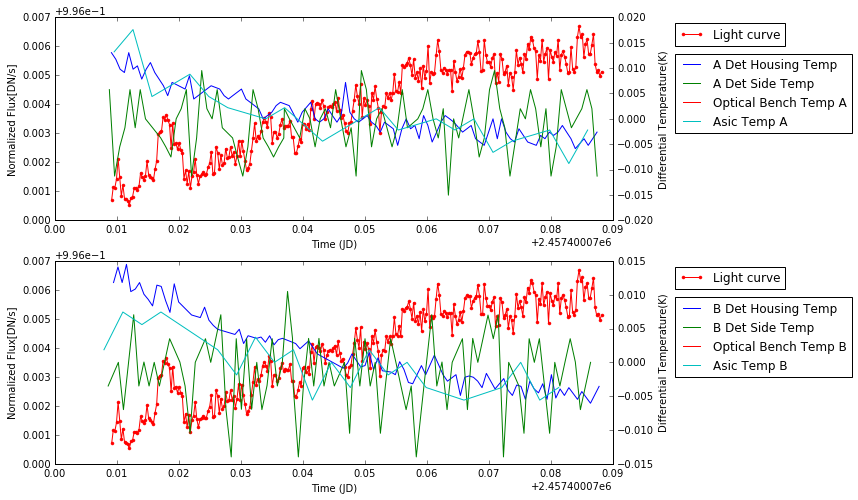

In [152]:
proper_lc(tvar1, data1)

## Test 2 (WLP8SUB640)

In [153]:
hdu_filenames_a12 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8SUB640-6012195832_1_481_SE_2016-01-12T20h57m57/*.slp.fits')
len(hdu_filenames_a12)

60

In [154]:
hdu_filenames_b42 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8SUB640-6012200140_1_489_SE_2016-01-12T20h58m27/*.slp.fits')
len(hdu_filenames_b42)

60

In [155]:
centers_a12 = rl.gen_center_g2d(326,320,5,400,2,2,0,hdu_filenames_a12)[0]
centers_b42 = rl.gen_center_g2d(319,316,5,500,2,2,0,hdu_filenames_b42)[0]
data2 = rl.average_residual_flux(centers_a12, centers_b42, 90, 100, 110, hdu_filenames_a12, hdu_filenames_b42)

In [156]:
tvar2 = time_vars(hdu_filenames_a12)
tvar2

(2457400.3369879746,
 2457400.3573041204,
 [2197, 38260, 0, 700, 2027, 38741, 0, 719],
 [2221, 38282, 0, 706, 2050, 38766, 0, 725])

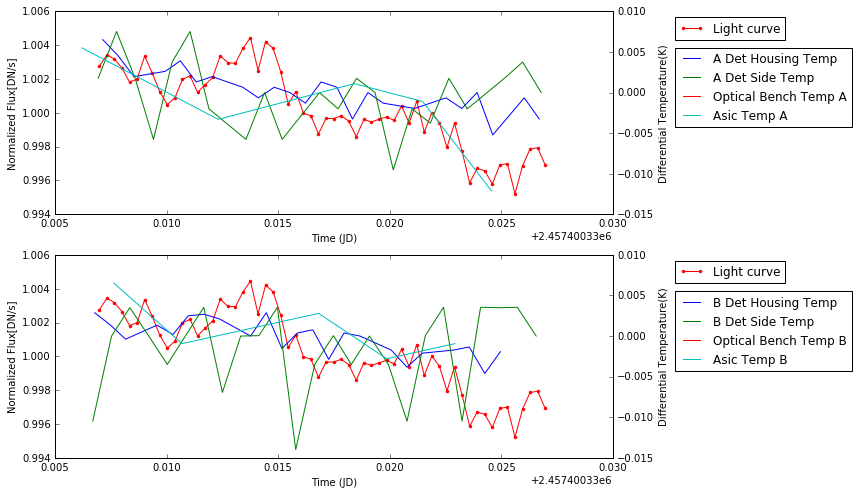

In [157]:
proper_lc(tvar2, data2)

## Test 3 (FULLQ)

In [158]:
hdu_filenames_a13 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULLQ-6013001651_1_481_SE_2016-01-13T01h03m43/*.red.fits')
len(hdu_filenames_a13)

55

In [159]:
hdu_filenames_b43 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULLQ-6013002009_1_489_SE_2016-01-13T01h03m23/*.red.fits')
len(hdu_filenames_b43)

55

In [160]:
centers_a13 = rl.gen_center_g2d(1405,1036,5,400,4,4,0,hdu_filenames_a13, red_files = True)[0]
centers_b43 = rl.gen_center_g2d(828,821,5,600,4,4,0,hdu_filenames_b43, red_files = True)[0]
data3 = rl.average_residual_flux(centers_a13, centers_b43, 60, 80, 90, 
                                 hdu_filenames_a13, hdu_filenames_b43, red_files = True)

In [161]:
tvar3 = time_vars(hdu_filenames_a13)
tvar3

(2457400.518157662,
 2457400.538661898,
 [2421, 38733, 0, 756, 2226, 39224, 0, 765],
 [2446, 38756, 0, 759, 2246, 39245, 0, 772])

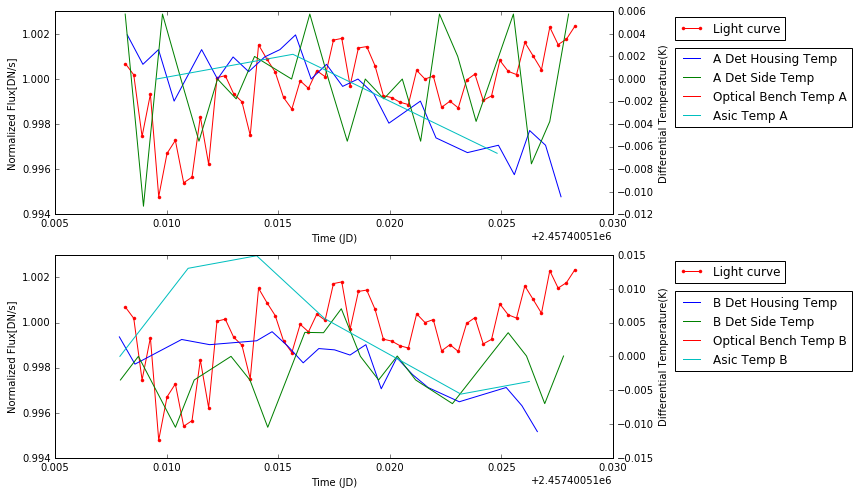

In [162]:
proper_lc(tvar3, data3)

## Test 4 (FULL1)

In [163]:
hdu_filenames_a14 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL1-6012051326_1_481_SE_2016-01-12T08h55m24/*.red.fits')
len(hdu_filenames_a14)

225

In [164]:
hdu_filenames_b44 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL1-6012051528_1_489_SE_2016-01-12T08h30m07/*.red.fits')
len(hdu_filenames_b44)

225

In [165]:
centers_a14 = rl.gen_center_g2d(1405,1036,5,400,4,4,0,hdu_filenames_a14, red_files = True)[0]
centers_b44 = rl.gen_center_g2d(828,821,5,600,4,4,0,hdu_filenames_b44, red_files = True)[0]
data4 = rl.average_residual_flux(centers_a14, centers_b44, 60, 80, 90, 
                                 hdu_filenames_a14, hdu_filenames_b44, red_files = True)

In [166]:
tvar4 = time_vars(hdu_filenames_a14)
tvar4

(2457399.720659479,
 2457399.8045404167,
 [1472, 36275, 0, 540, 1342, 36780, 0, 548],
 [1571, 36364, 0, 557, 1435, 36861, 0, 569])

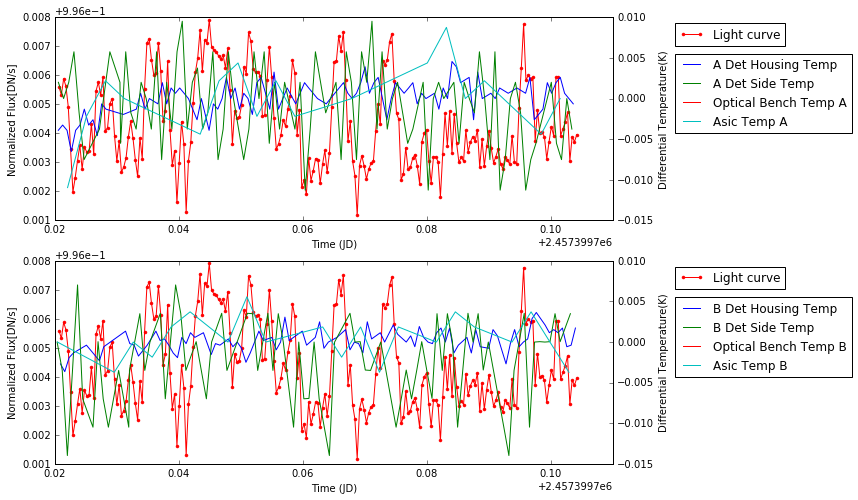

In [167]:
proper_lc(tvar4, data4)

## Test 5 (FULL2)

In [168]:
hdu_filenames_a15 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL2-6012072417_1_481_SE_2016-01-12T10h40m58/*.red.fits')
len(hdu_filenames_a15)

225

In [169]:
hdu_filenames_b45 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL2-6012072532_1_489_SE_2016-01-12T11h09m06/*.red.fits')
len(hdu_filenames_b45)

225

In [170]:
centers_a15 = rl.gen_center_g2d(1405,1036,5,400,4,4,0,hdu_filenames_a15, red_files = True)[0]
centers_b45 = rl.gen_center_g2d(828,821,5,600,4,4,0,hdu_filenames_b45, red_files = True)[0]
data5 = rl.average_residual_flux(centers_a15, centers_b45, 60, 80, 90, 
                                 hdu_filenames_a15, hdu_filenames_b45, red_files = True)

In [171]:
tvar5 = time_vars(hdu_filenames_a15)
tvar5

(2457399.810380961,
 2457399.894261898,
 [1578, 36389, 0, 560, 1442, 36886, 0, 570],
 [1672, 36475, 0, 579, 1539, 36973, 0, 593])

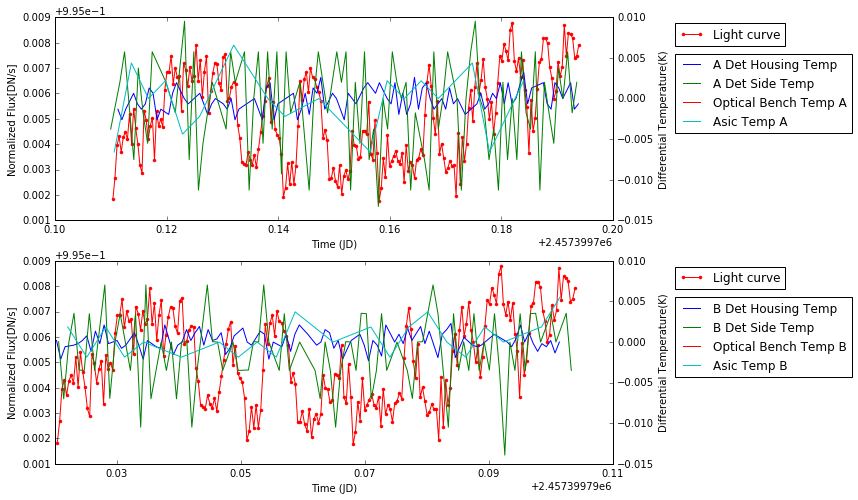

In [172]:
proper_lc(tvar5, data5)

## Test 6 (FULL3)

In [173]:
hdu_filenames_a16 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL3-6012093326_1_481_SE_2016-01-12T12h47m44/*.red.fits')
len(hdu_filenames_a16)

225

In [174]:
hdu_filenames_b46 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL3-6012093432_1_489_SE_2016-01-12T12h52m21/*.red.fits')
len(hdu_filenames_b46)

225

In [175]:
centers_a16 = rl.gen_center_g2d(1405,1036,5,400,4,4,0,hdu_filenames_a16, red_files = True)[0]
centers_b46 = rl.gen_center_g2d(828,821,5,600,4,4,0,hdu_filenames_b46, red_files = True)[0]
data6 = rl.average_residual_flux(centers_a16, centers_b46, 60, 80, 90, 
                                 hdu_filenames_a16, hdu_filenames_b46, red_files = True)

In [176]:
tvar6 = time_vars(hdu_filenames_a16)
tvar6

(2457399.900102442,
 2457399.98398338,
 [1676, 36499, 0, 581, 1547, 36997, 0, 595],
 [1773, 36590, 0, 603, 1636, 37080, 0, 616])

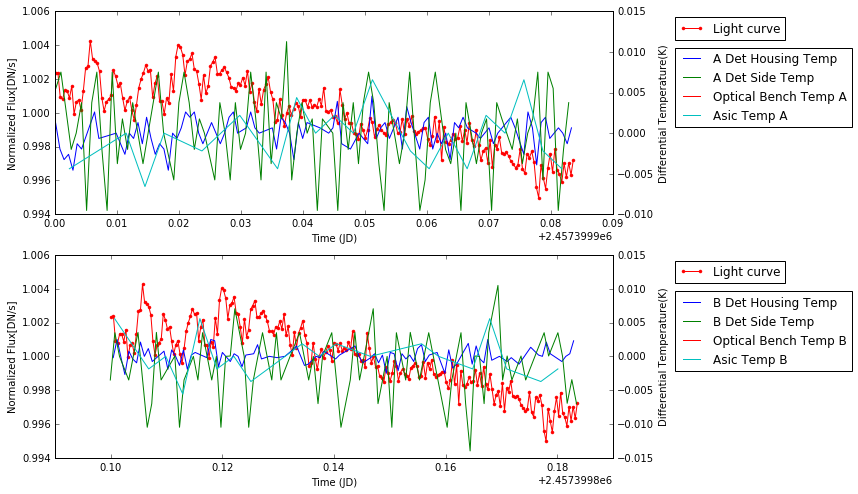

In [177]:
proper_lc(tvar6, data6)

## Test 7 (FULL4)

In [178]:
hdu_filenames_a17 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL4-6012114105_1_481_SE_2016-01-12T14h25m53/*.red.fits')
len(hdu_filenames_a17)

225

In [179]:
hdu_filenames_b47 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL4-6012114212_1_489_SE_2016-01-12T14h58m10/*.red.fits')
len(hdu_filenames_b47)

225

In [180]:
centers_a17 = rl.gen_center_g2d(1405,1036,5,400,4,4,0,hdu_filenames_a17, red_files = True)[0]
centers_b47 = rl.gen_center_g2d(828,821,5,600,4,4,0,hdu_filenames_b47, red_files = True)[0]
data7 = rl.average_residual_flux(centers_a17, centers_b47, 60, 80, 90, 
                                 hdu_filenames_a17, hdu_filenames_b47, red_files = True)

In [181]:
tvar7 = time_vars(hdu_filenames_a17)
tvar7

(2457399.988705405,
 2457400.0725863427,
 [1779, 36619, 0, 604, 1641, 37103, 0, 618],
 [1878, 36707, 0, 626, 1734, 37195, 0, 642])

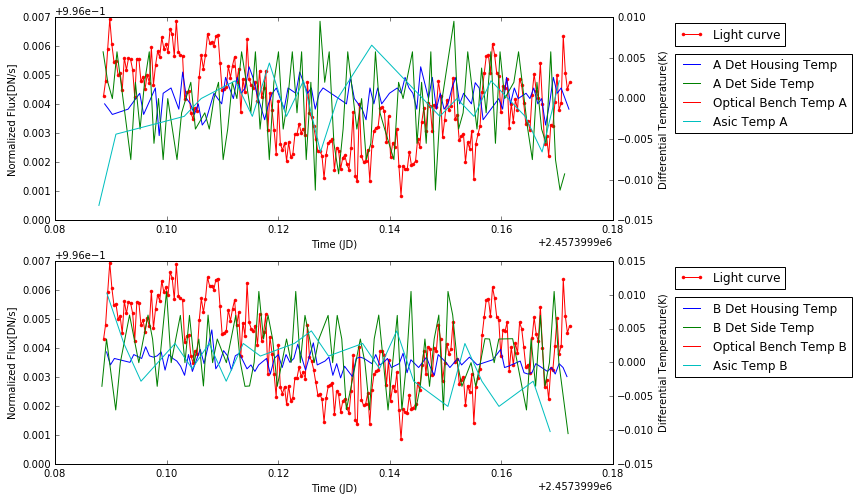

In [182]:
proper_lc(tvar7, data7)

## Test 8 (FULL5)

In [183]:
hdu_filenames_a18 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL5-6012184421_1_481_SE_2016-01-12T20h26m57/*.red.fits')
len(hdu_filenames_a18)

110

In [184]:
hdu_filenames_b48 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL5-6012185018_1_489_SE_2016-01-12T20h20m15/*.red.fits')
len(hdu_filenames_b48)

110

In [185]:
centers_a18 = rl.gen_center_g2d(1405,1036,5,400,4,4,0,hdu_filenames_a18, red_files = True)[0]
centers_b48 = rl.gen_center_g2d(828,821,5,600,4,4,0,hdu_filenames_b48, red_files = True)[0]
data8 = rl.average_residual_flux(centers_a18, centers_b48, 60, 80, 90, 
                                 hdu_filenames_a18, hdu_filenames_b48, red_files = True)

In [186]:
tvar8 = time_vars(hdu_filenames_a18)
tvar8

(2457400.2873786227,
 2457400.3283870835,
 [2139, 38184, 0, 685, 1968, 38668, 0, 705],
 [2187, 38226, 0, 697, 2017, 38711, 0, 716])

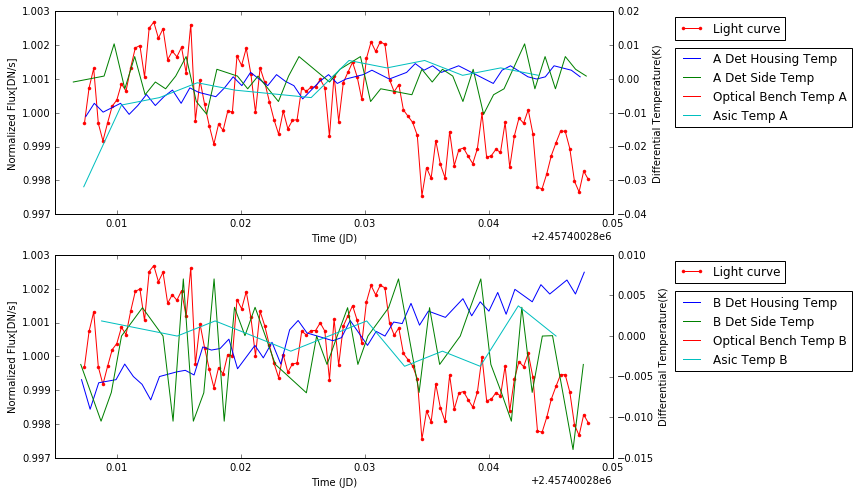

In [187]:
proper_lc(tvar8, data8)

## Test 9 (FULL6)

In [188]:
hdu_filenames_a19 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL6-6012204238_1_481_SE_2016-01-12T21h31m48/*.red.fits')
len(hdu_filenames_a19)

55

In [189]:
hdu_filenames_b49 = glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL6-6012204544_1_489_SE_2016-01-12T21h31m58/*.red.fits')
len(hdu_filenames_b49)

55

In [190]:
centers_a19 = rl.gen_center_g2d(1405,1036,5,400,4,4,0,hdu_filenames_a19, red_files = True)[0]
centers_b49 = rl.gen_center_g2d(828,821,5,600,4,4,0,hdu_filenames_b49, red_files = True)[0]
data9 = rl.average_residual_flux(centers_a19, centers_b49, 60, 80, 90, 
                                 hdu_filenames_a19, hdu_filenames_b49, red_files = True)

In [191]:
tvar9 = time_vars(hdu_filenames_a19)
tvar9

(2457400.367544329,
 2457400.388048565,
 [2235, 38313, 0, 710, 2065, 38798, 0, 727],
 [2260, 38335, 0, 717, 2088, 38820, 0, 732])

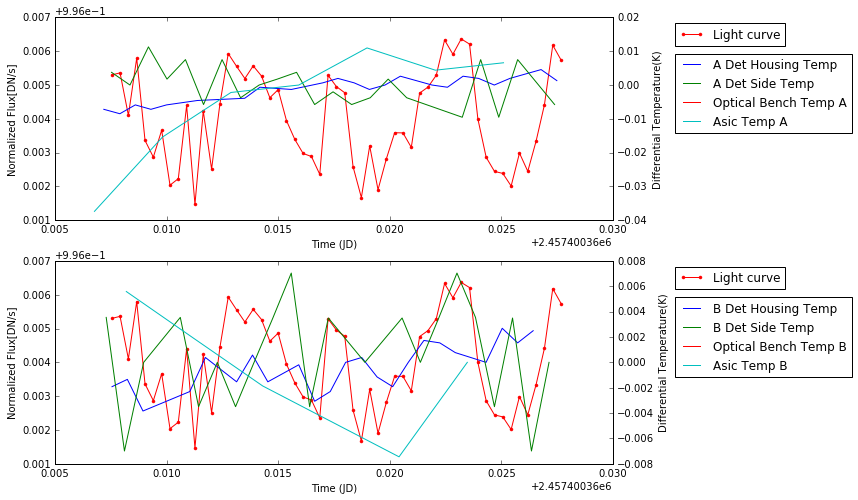

In [192]:
proper_lc(tvar9, data9)

## Test 10 (FULL7)

In [193]:
hdu_filenames_a110 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL7-*_481_SE_*/*.red.fits'))
len(hdu_filenames_a110)

20

In [194]:
hdu_filenames_b410 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL7-*_489_SE_*/*.red.fits'))
len(hdu_filenames_b410)

20

In [195]:
centers_a110 = rl.gen_center_g2d(1607,1036,5,4000,4,4,0,hdu_filenames_a110, red_files = True)[0]
centers_b410 = rl.gen_center_g2d(1029,835,5,4500,4,4,0,hdu_filenames_b410, red_files = True)[0]
data10 = rl.average_residual_flux(centers_a110, centers_b410, 60, 80, 90, 
                                 hdu_filenames_a110, hdu_filenames_b410, red_files = True)

In [196]:
tvar10 = time_vars(hdu_filenames_a110)
tvar10

(2457400.3923984026,
 2457400.3998544794,
 [2264, 38365, 0, 718, 2093, 38847, 0, 734],
 [2274, 38374, 0, 720, 2100, 38856, 0, 736])

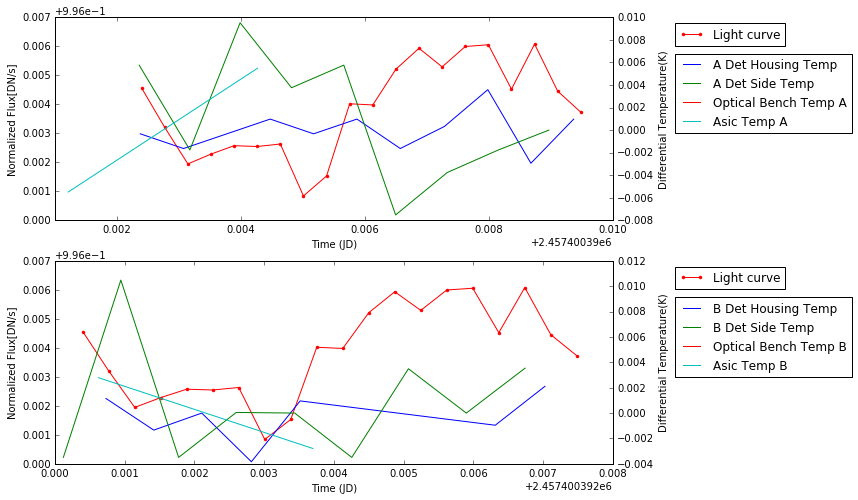

In [197]:
proper_lc(tvar10, data10)

## Test 11 (FULL9)

In [198]:
hdu_filenames_a111 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL9-*_481_SE_*/*.red.fits'))
len(hdu_filenames_a111)

20

In [199]:
hdu_filenames_b411 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL9-*_489_SE_*/*.red.fits'))
len(hdu_filenames_b411)

20

In [200]:
centers_a111 = rl.gen_center_g2d(1407,1236,5,4000,4,4,0,hdu_filenames_a111, red_files = True)[0]
centers_b411 = rl.gen_center_g2d(830,1019,5,4500,4,4,0,hdu_filenames_b411, red_files = True)[0]
data11 = rl.average_residual_flux(centers_a111, centers_b411, 60, 80, 90, 
                                 hdu_filenames_a111, hdu_filenames_b411, red_files = True)

In [201]:
tvar11 = time_vars(hdu_filenames_a111)
tvar11

(2457400.4129021065,
 2457400.4203581945,
 [2290, 38430, 0, 723, 2112, 38913, 0, 738],
 [2299, 38438, 0, 726, 2123, 38922, 0, 740])

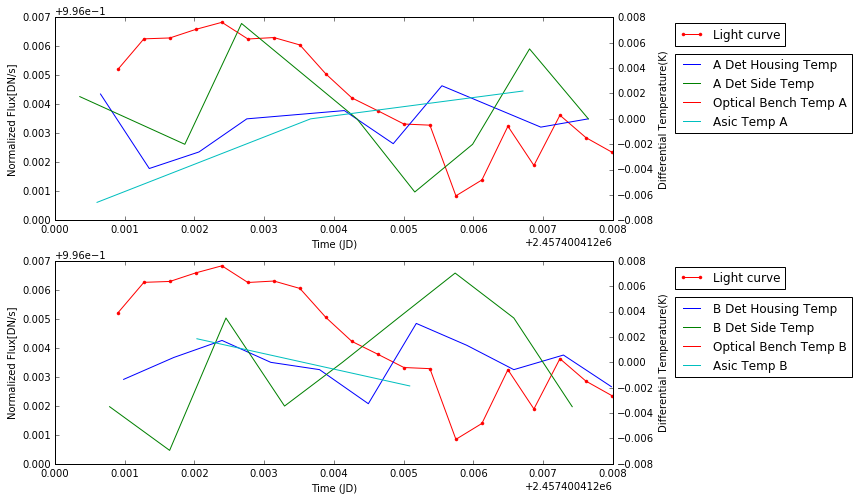

In [202]:
proper_lc(tvar11, data11)

## Test 12 (FULL10)

In [203]:
hdu_filenames_a112 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL10-*_481_SE_*/*.red.fits'))
len(hdu_filenames_a112)

20

In [204]:
hdu_filenames_b412 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL10-*_489_SE_*/*.red.fits'))
len(hdu_filenames_b412)

20

In [205]:
centers_a112 = rl.gen_center_g2d(1808,1237,5,4000,4,4,0,hdu_filenames_a112, red_files = True)[0]
centers_b412 = rl.gen_center_g2d(1227,1052,5,5000,4,4,0,hdu_filenames_b412, red_files = True)[0]
data12 = rl.average_residual_flux(centers_a112, centers_b412, 60, 80, 90, 
                                 hdu_filenames_a112, hdu_filenames_b412, red_files = True)

In [206]:
tvar12 = time_vars(hdu_filenames_a112)
tvar12

(2457400.423092477,
 2457400.430548565,
 [2302, 38462, 0, 727, 2125, 38946, 0, 740],
 [2313, 38470, 0, 729, 2134, 38954, 0, 742])

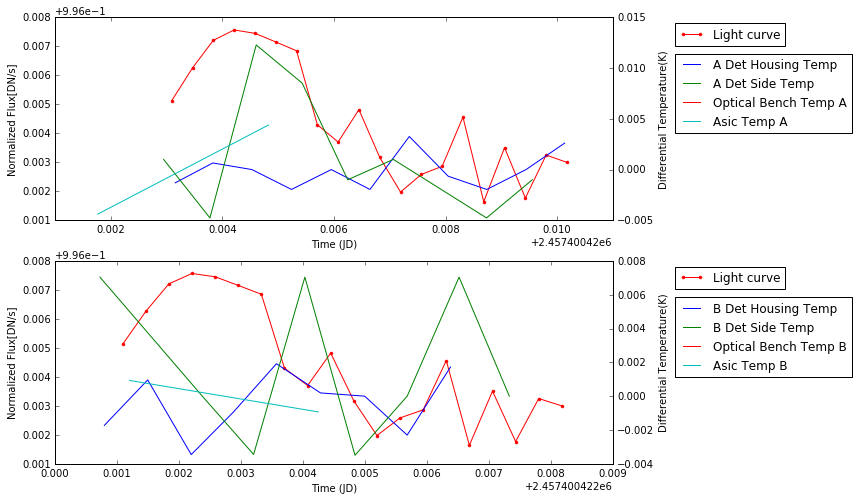

In [207]:
proper_lc(tvar12, data12)

## Test 13 (FULL11)

In [208]:
hdu_filenames_a113 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL11-*_481_SE_*/*.red.fits'))
len(hdu_filenames_a113)

20

In [209]:
hdu_filenames_b413 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL11-*_489_SE_*/*.red.fits'))
len(hdu_filenames_b413)

20

In [210]:
centers_a113 = rl.gen_center_g2d(1808,1037,5,4000,4,4,0,hdu_filenames_a113, red_files = True)[0]
centers_b413 = rl.gen_center_g2d(1228,851,5,4500,4,4,0,hdu_filenames_b413, red_files = True)[0]
data13 = rl.average_residual_flux(centers_a113, centers_b413, 60, 80, 90, 
                                 hdu_filenames_a113, hdu_filenames_b413, red_files = True)

In [211]:
tvar13 = time_vars(hdu_filenames_a113)
tvar13

(2457400.433282847,
 2457400.440738935,
 [2316, 38498, 0, 730, 2137, 38980, 0, 743],
 [2324, 38503, 0, 732, 2145, 38988, 0, 745])

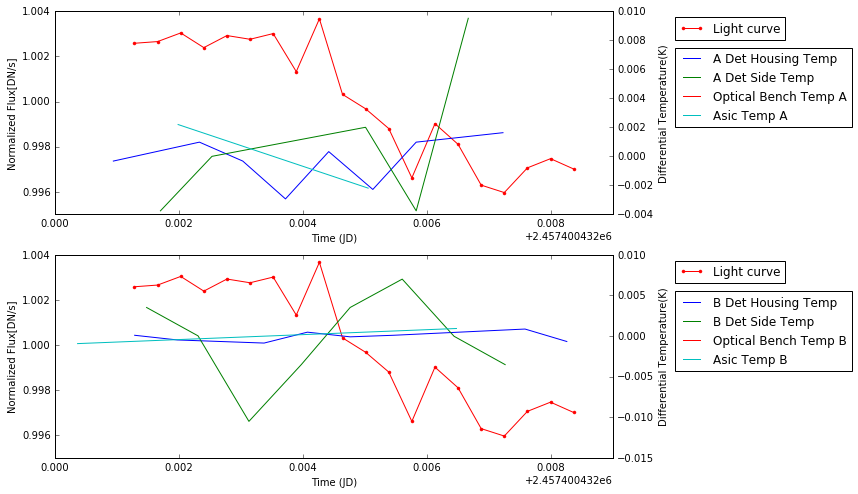

In [212]:
proper_lc(tvar13, data13)

## Test 14 (FULL12)

In [215]:
hdu_filenames_a114 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL12-*_481_SE_*/*.red.fits'))
len(hdu_filenames_a114)

20

In [216]:
hdu_filenames_b414 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL12-*_489_SE_*/*.red.fits'))
len(hdu_filenames_b414)

20

In [217]:
centers_a114 = rl.gen_center_g2d(1808,838,5,4000,4,4,0,hdu_filenames_a114, red_files = True)[0]
centers_b414 = rl.gen_center_g2d(1228,653,5,6500,4,4,0,hdu_filenames_b414, red_files = True)[0]
data14 = rl.average_residual_flux(centers_a114, centers_b414, 60, 80, 90, 
                                 hdu_filenames_a114, hdu_filenames_b414, red_files = True)

In [218]:
tvar14 = time_vars(hdu_filenames_a114)
tvar14

(2457400.4434724767,
 2457400.4509285646,
 [2327, 38531, 0, 733, 2148, 39009, 0, 746],
 [2337, 38539, 0, 735, 2157, 39017, 0, 748])

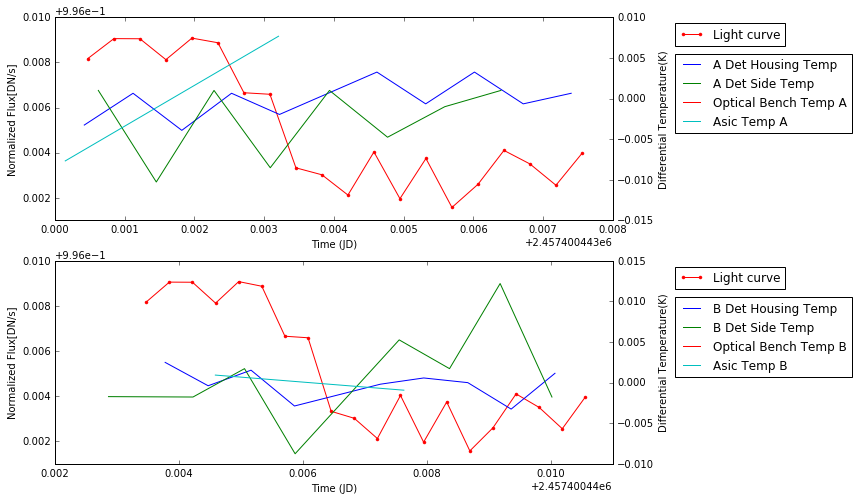

In [219]:
proper_lc(tvar14, data14)

## Test 15 (FULL13)

In [221]:
hdu_filenames_a115 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL13-*_481_SE_*/*.red.fits'))
len(hdu_filenames_a115)

20

In [222]:
hdu_filenames_b415 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL13-*_489_SE_*/*.red.fits'))
len(hdu_filenames_b415)

20

In [226]:
centers_a115 = rl.gen_center_g2d(1407,838,5,4000,4,4,0,hdu_filenames_a115, red_files = True)[0]
centers_b415 = rl.gen_center_g2d(831,623,5,6500,4,4,0,hdu_filenames_b415, red_files = True)[0]
data15 = rl.average_residual_flux(centers_a115, centers_b415, 60, 80, 90, 
                                 hdu_filenames_a115, hdu_filenames_b415, red_files = True)

In [227]:
tvar15 = time_vars(hdu_filenames_a115)
tvar15

(2457400.453786551,
 2457400.461242639,
 [2341, 38564, 0, 735, 2161, 39044, 0, 749],
 [2349, 38572, 0, 738, 2168, 39052, 0, 751])

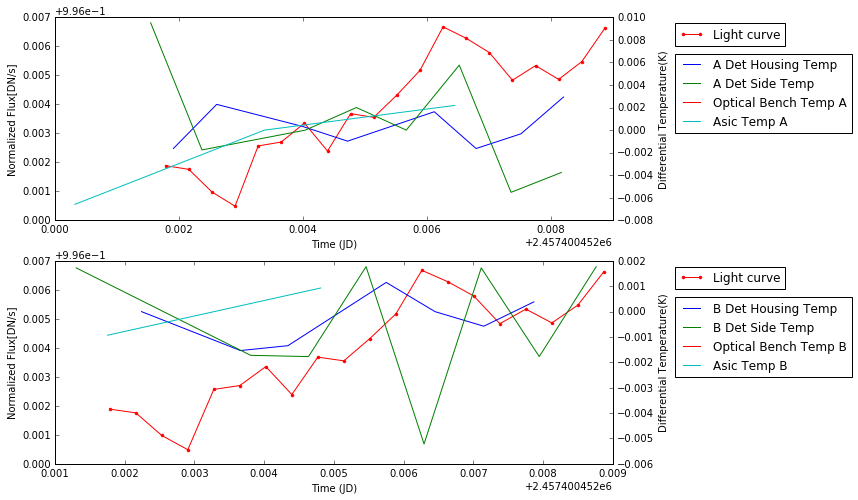

In [228]:
proper_lc(tvar15, data15)

## Test 16 (FULL14)

In [232]:
hdu_filenames_a116 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL14-*_481_SE_*/*.red.fits'))
len(hdu_filenames_a116)

20

In [233]:
hdu_filenames_b416 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL14-*_489_SE_*/*.red.fits'))
len(hdu_filenames_b416)

20

In [234]:
centers_a116 = rl.gen_center_g2d(1407,838,5,4000,4,4,0,hdu_filenames_a116, red_files = True)[0]
centers_b416 = rl.gen_center_g2d(831,623,5,6500,4,4,0,hdu_filenames_b416, red_files = True)[0]
data16 = rl.average_residual_flux(centers_a116, centers_b416, 60, 80, 90, 
                                 hdu_filenames_a116, hdu_filenames_b416, red_files = True)

In [235]:
tvar16 = time_vars(hdu_filenames_a116)
tvar16

(2457400.4639769215,
 2457400.4714330095,
 [2353, 38594, 0, 739, 2171, 39081, 0, 752],
 [2363, 38603, 0, 741, 2180, 39090, 0, 754])

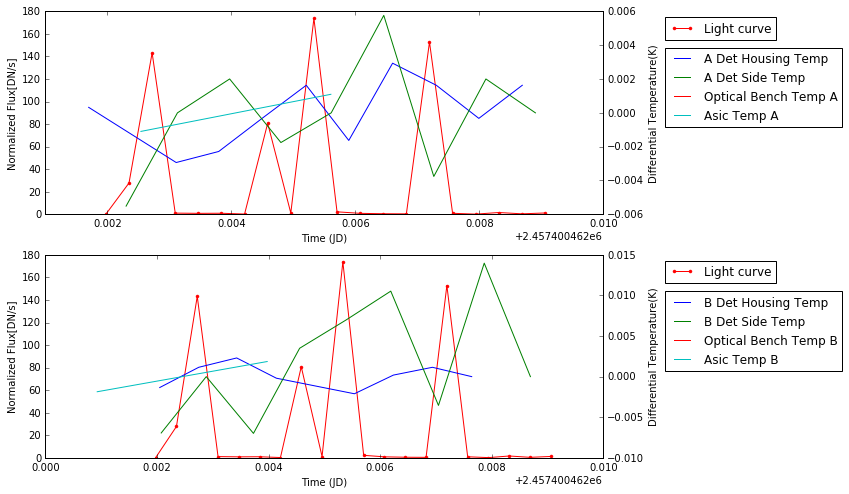

In [236]:
proper_lc(tvar16, data16)

## Test 17 (FULL0)

In [242]:
hdu_filenames_a117 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL0-*_481_SE_*/*.red.fits'))
len(hdu_filenames_a117)

20

In [243]:
hdu_filenames_b417 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8FULL0-*_489_SE_*/*.red.fits'))
len(hdu_filenames_b417)

20

In [244]:
centers_a117 = rl.gen_center_g2d(1408,1038,5,4000,4,4,0,hdu_filenames_a117, red_files = True)[0]
centers_b417 = rl.gen_center_g2d(831,822,5,6500,4,4,0,hdu_filenames_b417, red_files = True)[0]
data17 = rl.average_residual_flux(centers_a117, centers_b417, 60, 80, 90, 
                                 hdu_filenames_a117, hdu_filenames_b417, red_files = True)

In [245]:
tvar17 = time_vars(hdu_filenames_a117)
tvar17

(2457399.701646551,
 2457399.709102639,
 [1449, 36231, 0, 534, 1321, 36742, 0, 543],
 [1458, 36237, 0, 537, 1328, 36750, 0, 545])

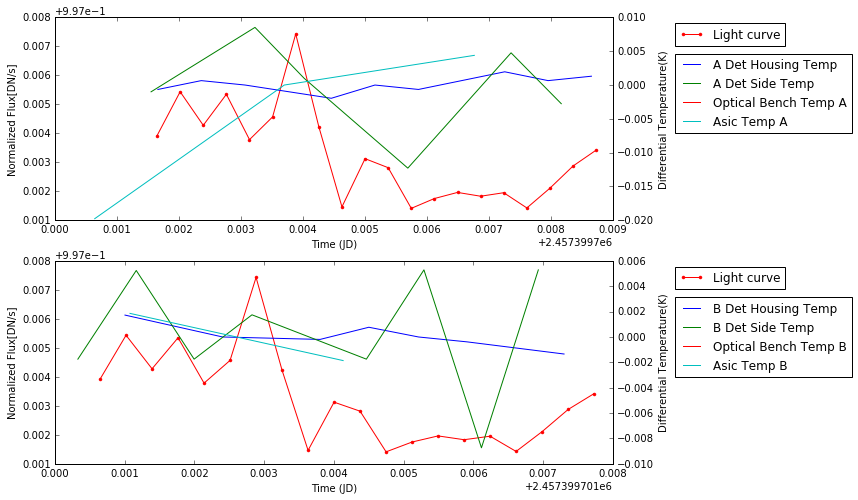

In [246]:
proper_lc(tvar17, data17)

## Test 18 (CLRSUB1)

In [247]:
hdu_filenames_a118 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821CLRSUB1-*_481_SE_*/*.red.fits'))
len(hdu_filenames_a118)

100

In [248]:
hdu_filenames_b418 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821CLRSUB1-*_489_SE_*/*.red.fits'))
len(hdu_filenames_b418)

100

In [251]:
hdu = fits.open(hdu_filenames_a118[4])
header = hdu[0].header
header['NGROUP']

3

In [252]:
centers_a118 = rl.gen_center_g2d(164,161,5,14000,2,2,0,hdu_filenames_a118, red_files = True, rf_slope = True)[0]
centers_b418 = rl.gen_center_g2d(160,155,5,12500,2,2,0,hdu_filenames_b418, red_files = True, rf_slope = True)[0]
data18 = rl.average_residual_flux(centers_a118, centers_b418, 3, 9, 10, 
                                 hdu_filenames_a118, hdu_filenames_b418, red_files = True, rf_slope = True)

In [253]:
tvar18 = time_vars(hdu_filenames_a118)
tvar18

(2457400.2286028243,
 2457400.233536713,
 [2069, 37924, 0, 671, 1907, 38419, 0, 687],
 [2075, 37930, 0, 672, 1913, 38424, 0, 688])

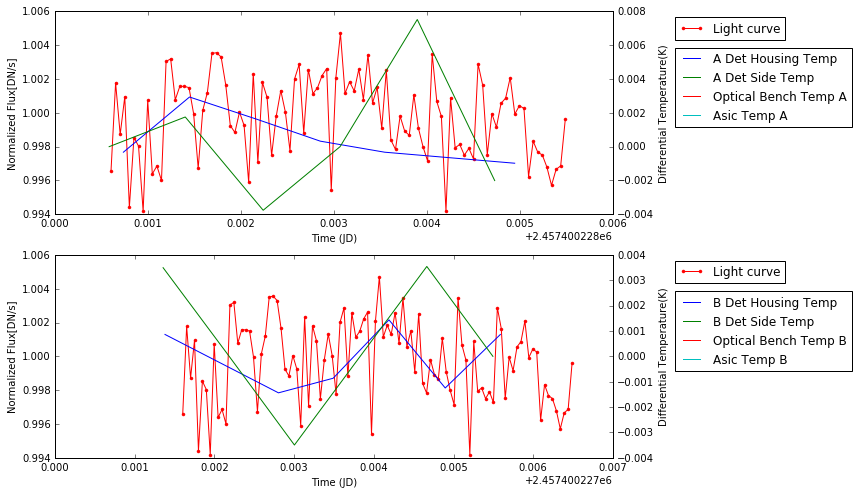

In [254]:
proper_lc(tvar18, data18)

## Test 19 (CLRSUB2)

In [265]:
hdu_filenames_a119 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821CLRSUB2-*_481_SE_*/*.red.fits'))
len(hdu_filenames_a119)

100

In [266]:
hdu_filenames_b419 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821CLRSUB2-*_489_SE_*/*.red.fits'))
len(hdu_filenames_b419)

100

In [267]:
centers_a119 = rl.gen_center_g2d(164,161,5,14000,2,2,0,hdu_filenames_a119, red_files = True, rf_slope = True)[0]
centers_b419 = rl.gen_center_g2d(160,155,5,12500,2,2,0,hdu_filenames_b419, red_files = True, rf_slope = True)[0]
data19 = rl.average_residual_flux(centers_a119, centers_b419, 3, 9, 10, 
                                 hdu_filenames_a119, hdu_filenames_b419, red_files = True, rf_slope = True)

In [268]:
tvar19 = time_vars(hdu_filenames_a119)
tvar19

(2457400.2358309724,
 2457400.240764861,
 [2078, 37954, 0, 673, 1916, 38448, 0, 689],
 [2081, 37959, 0, 673, 1920, 38454, 0, 690])

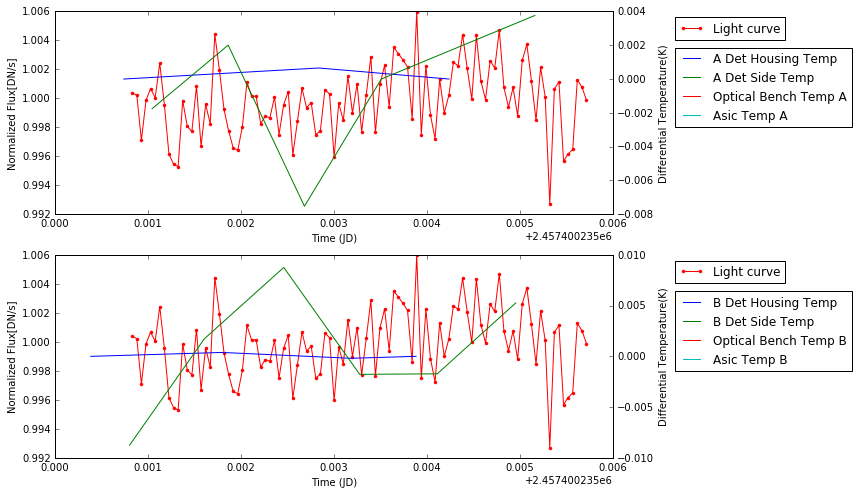

In [269]:
proper_lc(tvar19, data19)

## Test 20 (CLRSUB3)

In [270]:
hdu_filenames_a120 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821CLRSUB3-*_481_SE_*/*.red.fits'))
len(hdu_filenames_a120)

100

In [271]:
hdu_filenames_b420 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821CLRSUB3-*_489_SE_*/*.red.fits'))
len(hdu_filenames_b420)

100

In [272]:
centers_a120 = rl.gen_center_g2d(164,161,5,14000,2,2,0,hdu_filenames_a120, red_files = True, rf_slope = True)[0]
centers_b420 = rl.gen_center_g2d(160,155,5,12500,2,2,0,hdu_filenames_b420, red_files = True, rf_slope = True)[0]
data20 = rl.average_residual_flux(centers_a120, centers_b420, 3, 9, 10, 
                                 hdu_filenames_a120, hdu_filenames_b420, red_files = True, rf_slope = True)

In [273]:
tvar20 = time_vars(hdu_filenames_a120)
tvar20

(2457400.24305912,
 2457400.247993009,
 [2084, 37986, 0, 674, 1922, 38479, 0, 692],
 [2090, 37991, 0, 674, 1927, 38485, 0, 694])

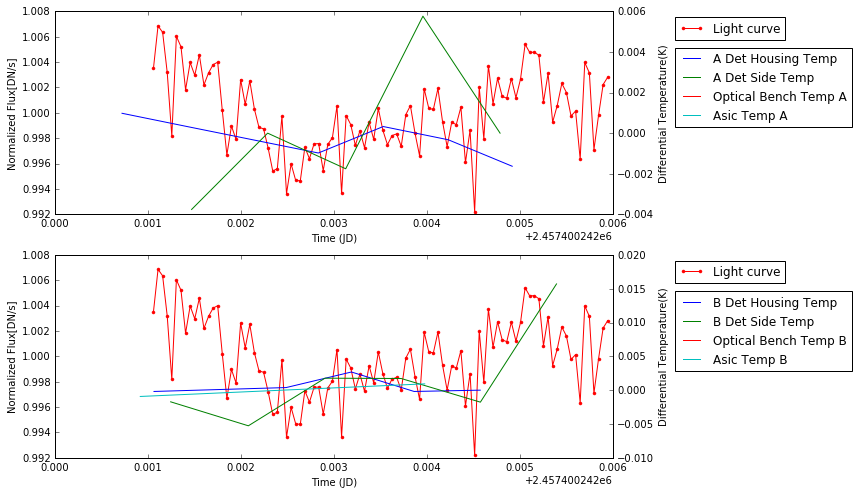

In [274]:
proper_lc(tvar20, data20)

## Test 21 (CLRSUB4)

In [275]:
hdu_filenames_a121 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821CLRSUB4-*_481_SE_*/*.red.fits'))
len(hdu_filenames_a121)

100

In [276]:
hdu_filenames_b421 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821CLRSUB4-*_489_SE_*/*.red.fits'))
len(hdu_filenames_b421)

100

In [277]:
centers_a121 = rl.gen_center_g2d(164,161,5,14000,2,2,0,hdu_filenames_a121, red_files = True, rf_slope = True)[0]
centers_b421 = rl.gen_center_g2d(160,155,5,12500,2,2,0,hdu_filenames_b421, red_files = True, rf_slope = True)[0]
data21 = rl.average_residual_flux(centers_a121, centers_b421, 3, 9, 10, 
                                 hdu_filenames_a121, hdu_filenames_b421, red_files = True, rf_slope = True)

In [278]:
tvar21 = time_vars(hdu_filenames_a121)
tvar21

(2457400.250173935,
 2457400.255107824,
 [2093, 38016, 0, 675, 1929, 38506, 0, 695],
 [2097, 38021, 0, 676, 1933, 38511, 0, 696])

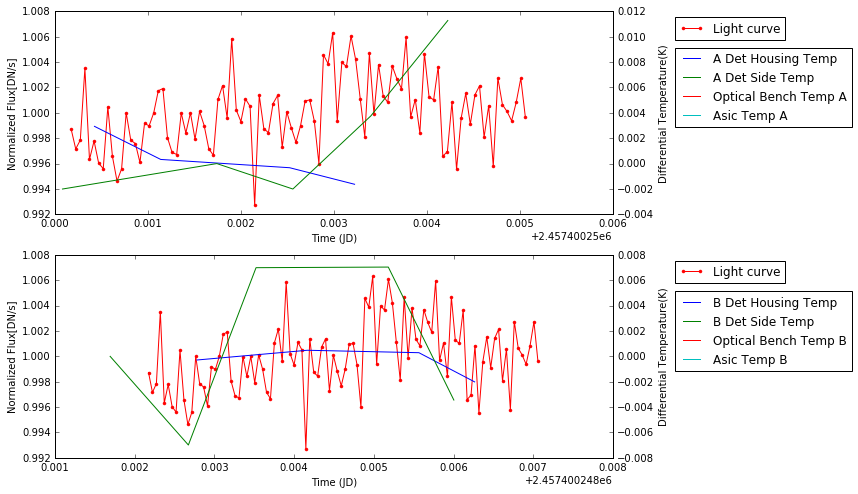

In [279]:
proper_lc(tvar21, data21)

## Test 22 (CLRSUB5)

In [280]:
hdu_filenames_a122 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821CLRSUB5-*_481_SE_*/*.red.fits'))
len(hdu_filenames_a122)

100

In [281]:
hdu_filenames_b422 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821CLRSUB5-*_489_SE_*/*.red.fits'))
len(hdu_filenames_b422)

100

In [282]:
centers_a122 = rl.gen_center_g2d(164,161,5,14000,2,2,0,hdu_filenames_a122, red_files = True, rf_slope = True)[0]
centers_b422 = rl.gen_center_g2d(160,155,5,12500,2,2,0,hdu_filenames_b422, red_files = True, rf_slope = True)[0]
data22 = rl.average_residual_flux(centers_a122, centers_b422, 3, 9, 10, 
                                 hdu_filenames_a122, hdu_filenames_b422, red_files = True, rf_slope = True)

In [283]:
tvar22 = time_vars(hdu_filenames_a122)
tvar22

(2457400.2575161573,
 2457400.2624500464,
 [2099, 38044, 0, 676, 1936, 38533, 0, 697],
 [2106, 38049, 0, 678, 1941, 38538, 0, 698])

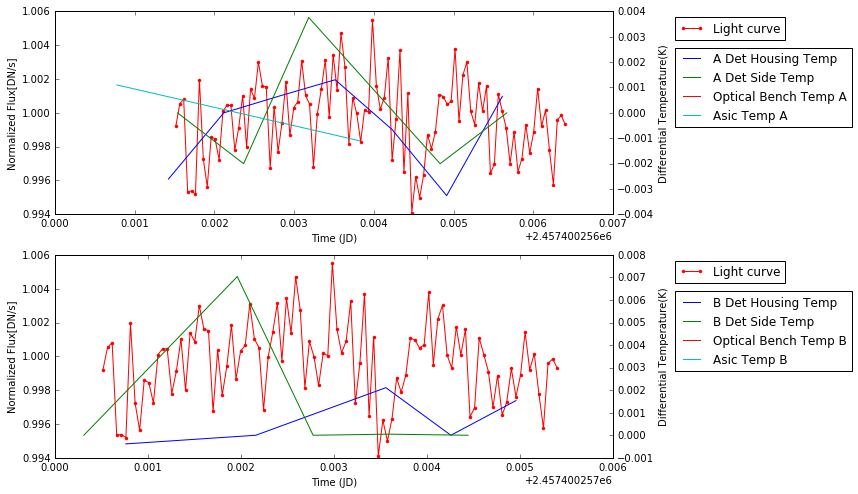

In [284]:
proper_lc(tvar22, data22)

## Test 23 (CLRSUB6)

In [285]:
hdu_filenames_a123 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821CLRSUB6-*_481_SE_*/*.red.fits'))
len(hdu_filenames_a123)

100

In [286]:
hdu_filenames_b423 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821CLRSUB6-*_489_SE_*/*.red.fits'))
len(hdu_filenames_b423)

100

In [287]:
centers_a123 = rl.gen_center_g2d(164,161,5,14000,2,2,0,hdu_filenames_a123, red_files = True, rf_slope = True)[0]
centers_b423 = rl.gen_center_g2d(160,155,5,12500,2,2,0,hdu_filenames_b423, red_files = True, rf_slope = True)[0]
data23 = rl.average_residual_flux(centers_a123, centers_b423, 3, 9, 10, 
                                 hdu_filenames_a123, hdu_filenames_b423, red_files = True, rf_slope = True)

In [288]:
tvar23 = time_vars(hdu_filenames_a123)
tvar23

(2457400.2648702315,
 2457400.2698041205,
 [2110, 38076, 0, 679, 1943, 38565, 0, 699],
 [2117, 38081, 0, 680, 1950, 38570, 0, 699])

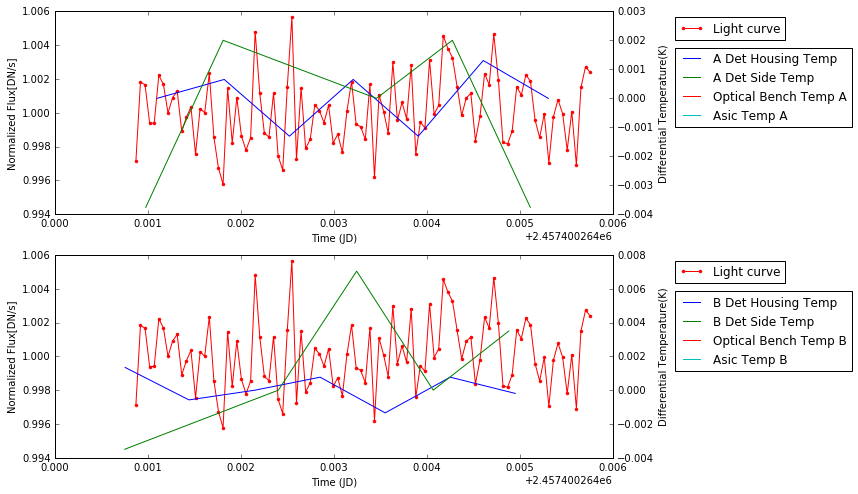

In [289]:
proper_lc(tvar23, data23)

## Test 24 (WLP8A1B4)

In [291]:
hdu_filenames_a124 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8A1B4-6012235318_1_484_SE_2016-01-13T00h29m51/*.red.fits'))
len(hdu_filenames_a124)

20

In [292]:
hdu_filenames_b424 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8A1B4-6012235624_1_486_SE_2016-01-13T00h29m41/*.red.fits'))
len(hdu_filenames_b424)

20

In [293]:
hdu = fits.open(hdu_filenames_a124[2])
header = hdu[0].header
header['NGROUP']

2

In [300]:
centers_a124 = rl.gen_center_g2d(802,1198,5,5000,2,2,0,hdu_filenames_a124, red_files = True, rf_slope = True)[0]
centers_b424 = rl.gen_center_g2d(1372,1598,5,5000,2,2,0,hdu_filenames_b424, red_files = True, rf_slope = True)[0]
data24 = rl.average_residual_flux(centers_a124, centers_b424, 90, 100, 110, 
                                 hdu_filenames_a124, hdu_filenames_b424, red_files = True, rf_slope = True)

In [301]:
tvar24 = time_vars(hdu_filenames_a124)
tvar24

(2457400.4991998845,
 2457400.5066559725,
 [2397, 38693, 0, 750, 2208, 39187, 0, 761],
 [2405, 38699, 0, 753, 2214, 39194, 0, 763])

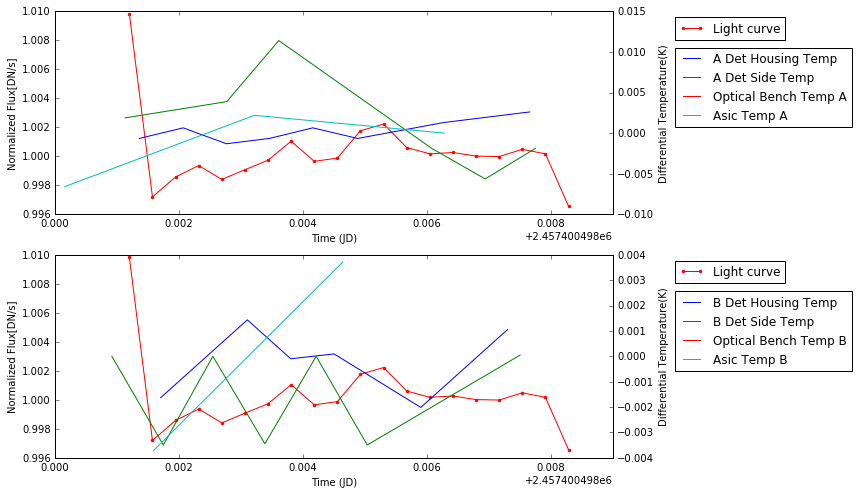

In [302]:
proper_lc(tvar24, data24)

## Test 25 (WLP8A2B3)

In [303]:
hdu_filenames_a125 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8A2B3-6012231915_1_482_SE_2016-01-12T23h49m21/*.red.fits'))
len(hdu_filenames_a125)

20

In [304]:
hdu_filenames_b425 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8A2B3-6012232242_1_488_SE_2016-01-12T23h50m52/*.red.fits'))
len(hdu_filenames_b425)

20

In [308]:
centers_a125 = rl.gen_center_g2d(749,1200,5,5000,2,2,0,hdu_filenames_a125, red_files = True, rf_slope = True)[0]
centers_b425 = rl.gen_center_g2d(1345,1434,5,5000,2,2,0,hdu_filenames_b425, red_files = True, rf_slope = True)[0]
data25 = rl.average_residual_flux(centers_a125, centers_b425, 90, 100, 110, 
                                 hdu_filenames_a125, hdu_filenames_b425, red_files = True, rf_slope = True)

In [309]:
tvar25 = time_vars(hdu_filenames_a125)
tvar25

(2457400.475837662,
 2457400.48329375,
 [2368, 38625, 0, 743, 2184, 39119, 0, 755],
 [2376, 38629, 0, 745, 2193, 39127, 0, 756])

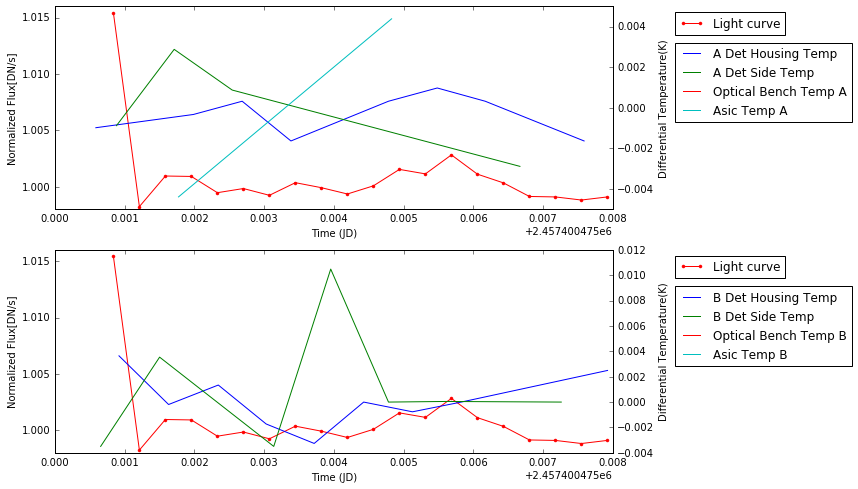

In [310]:
proper_lc(tvar25, data25)

## Test 26 (WLP8A3B2)

In [311]:
hdu_filenames_a126 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8A3B2-6012233622_1_483_SE_2016-01-13T00h02m02/*.red.fits'))
len(hdu_filenames_a126)

20

In [312]:
hdu_filenames_b426 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8A3B2-6012233935_1_487_SE_2016-01-13T00h01m52/*.red.fits'))
len(hdu_filenames_b426)

20

In [313]:
centers_a126 = rl.gen_center_g2d(1403,1200,5,5000,2,2,0,hdu_filenames_a126, red_files = True, rf_slope = True)[0]
centers_b426 = rl.gen_center_g2d(827,805,5,5000,2,2,0,hdu_filenames_b426, red_files = True, rf_slope = True)[0]
data26 = rl.average_residual_flux(centers_a126, centers_b426, 90, 100, 110, 
                                 hdu_filenames_a126, hdu_filenames_b426, red_files = True, rf_slope = True)

In [314]:
tvar26 = time_vars(hdu_filenames_a126)
tvar26

(2457400.4876443287,
 2457400.4951004167,
 [2381, 38659, 0, 747, 2196, 39152, 0, 757],
 [2391, 38667, 0, 749, 2203, 39158, 0, 759])

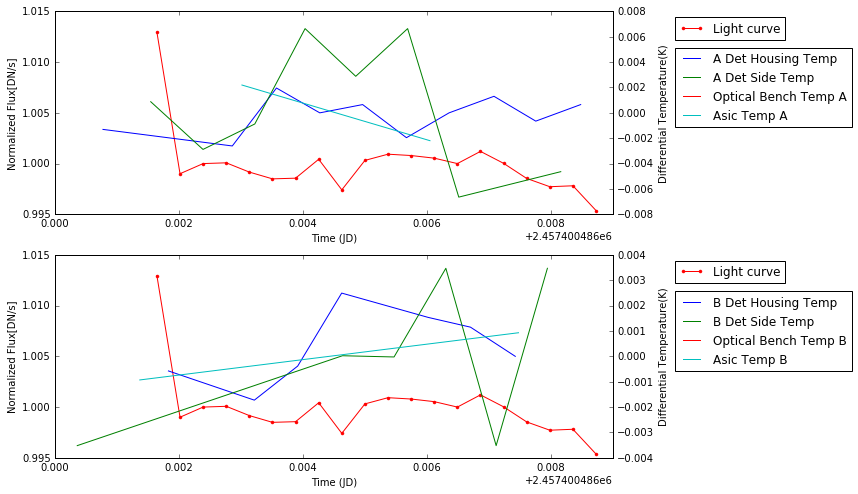

In [315]:
proper_lc(tvar26, data26)

## Test 27 (WLP8CHECK)

In [316]:
hdu_filenames_a127 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8CHECK-6012041445_1_481_SE_2016-01-12T04h36m43/*.red.fits'))
len(hdu_filenames_a127)

4

In [317]:
hdu_filenames_b427 = np.sort(glob.glob('/data1/tso_analysis/all_tso_cv3/raw_separated_MMM'
                              '/NRCN821WLP8CHECK-6012042137_1_489_SE_2016-01-12T04h37m23/*.red.fits'))
len(hdu_filenames_b427)

4

In [318]:
centers_a127 = rl.gen_center_g2d(1408,1038,5,5000,2,2,0,hdu_filenames_a127, red_files = True, rf_slope = True)[0]
centers_b427 = rl.gen_center_g2d(830,821,5,5000,2,2,0,hdu_filenames_b427, red_files = True, rf_slope = True)[0]
data27 = rl.average_residual_flux(centers_a127, centers_b427, 90, 100, 110, 
                                 hdu_filenames_a127, hdu_filenames_b427, red_files = True, rf_slope = True)

In [319]:
tvar27 = time_vars(hdu_filenames_a127)
tvar27

(2457399.6833788194,
 2457399.684870046,
 [1426, 36188, 0, 529, 1301, 36698, 0, 539],
 [1428, 36190, 0, 530, 1304, 36700, 0, 539])

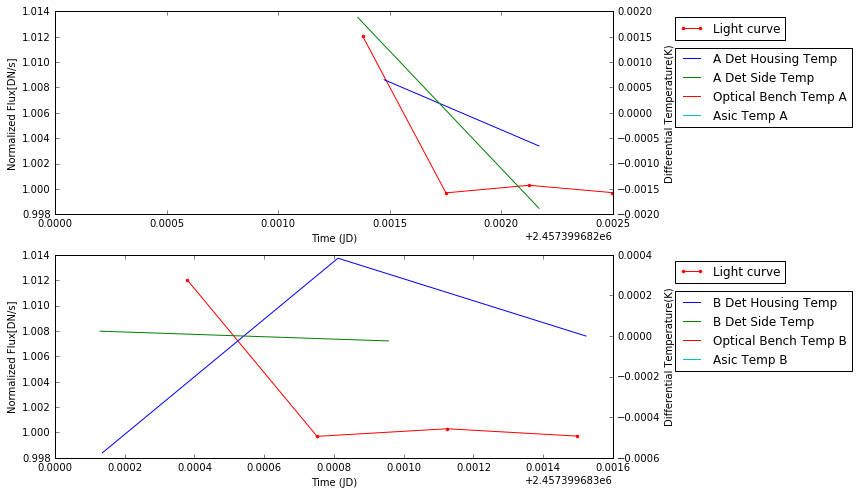

In [320]:
proper_lc(tvar27, data27)